In [5]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [6]:
from utils import base_configs, deps, tr_va_te_split #, models_def, shap_explain
from utils.helpers import rw_csv_helpers, feature_distr_helpers, logging_helpers, tr_va_te_eval_helpers, tr_va_te_result_plot

In [7]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
# import utils._1_3_train_valid_test_split as _1_3_tvts
# import utils._2_ml_rf as _2_ml_rf

### 0 Data load

In [32]:
CONFIGS = base_configs.get_base_configs()

df_hints6 = "ip/3_cleanedEncoded/hints6_public_filtered_v1_cleaned_encoded.csv"
df_hints7 = "ip/3_cleanedEncoded/....csv"
df_hints6_7 = "ip/3_cleanedEncoded/hints6_7_cleaned_encoded.csv"
df_orig = rw_csv_helpers.read_csv_file(df_hints6_7, verbose = 1)
# Alternatively,
# df_orig = rw_csv_helpers.read_csv_file(CONFIGS['IP_CSV_HINTS6_CLEANED_ENCODED'], verbose = 1)


Loaded: /home/ppanta/puru_proj/proj_v0/hints6_v0/ip/3_cleanedEncoded/hints6_7_cleaned_encoded.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (10581, 26)
────────────────────────────────────────────────────────────────────────────────
All columns: ['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes', 'MedConditions_HighBP', 'MedConditions_HeartCondition', 'MedConditions_LungDisease', 'MedConditions_Depression', 'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI', 'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek', 'GeneralHealth_Excellent', 'GeneralHealth_VeryGood', 'GeneralHealth_Good', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'smokeStat_Current', 'smokeStat_Former', 'smokeStat_Never', 'eCigUse_Current', 'eCigUse_Former', 'eCigUse_Never']


In [5]:
## READ THE FEATURE RANKING FILE:

import os
import pandas as pd

CONFIGS["RUN_TS"] = "20251118_101434"

import os
import pandas as pd

run_ts = CONFIGS["RUN_TS"]
base_dir = f"op/tr_va_te_metric_shap_{run_ts}"

csv_path = os.path.join(
    base_dir,
    f"global_shap_{run_ts}_with_weightedSHAP_InclTabNetImp_WSA_ranked.csv"
)

# Read only 'feature' and Rank_ columns
rank_df = pd.read_csv(
    csv_path,
    usecols=lambda c: (c == "feature") or c.startswith("Rank_")
).set_index("feature")



# 1) For each Rank_ column, features sorted ascending
rank_cols = [c for c in rank_df.columns if c.startswith("Rank_")]

features_by_rank = {}  # dict: column name -> list of features in sorted order
for col in rank_cols:
    features_by_rank[col] = (
        rank_df
        .sort_values(col, ascending=True)
        .index
        .tolist()
    )

# Example: access arrays
# Rank_lr_shap,	Rank_rf_shap, Rank_mlp_shap, Rank_xgb_shap, Rank_xlstm_shap, Rank_tabnet_imp, Rank_WSA_SHAP_IMP
    
# features_by_wsa              -> list of features ordered by Rank_WSA_SHAP_IMP
# features_by_rank["Rank_lr_shap"]  -> list ordered by Rank_lr_shap
# features_by_rank["Rank_rf_shap"]  -> list ordered by Rank_rf_shap
# features_by_rank["Rank_mlp_shap"]  -> list ordered by Rank_mlp_shap
# features_by_rank["Rank_xgb_shap"]  -> list ordered by Rank_xgb_shap
# features_by_rank["Rank_xlstm_shap"]  -> list ordered by Rank_xlstm_shap
# features_by_rank["Rank_tabnet_shap"]  -> list ordered by Rank_tabnet_shap
# features_by_rank["Rank_WSA_SHAP_IMP"]  -> list ordered by Rank_WSA_SHAP_IMP

In [ ]:
df = df_orig.copy()

target_col_name = CONFIGS['TARGET_COL_NAME']  # "MedConditions_HeartCondition"

# ---- Top 10 by AWSA (Rank_WSA_SHAP_IMP) ----
top10_WSA = features_by_rank["Rank_WSA_SHAP_IMP"][:10]   # list of 10 feature names
cols_WSA = top10_WSA + [target_col_name]                 # ensure target column is included
df_Rank_WSA_SHAP_IMP_10 = df[cols_WSA].copy()

# ---- Top 10 by RF SHAP (Rank_rf_shap) ----
top10_rf = features_by_rank["Rank_rf_shap"][:10]         # list of 10 feature names
cols_rf = top10_rf + [target_col_name]
df_Rank_rf_shap_10 = df[cols_rf].copy()

In [10]:
df = df_orig.copy()

target_col_name = CONFIGS['TARGET_COL_NAME']  # "MedConditions_HeartCondition"

# ---- Top 10 by AWSA (Rank_WSA_SHAP_IMP) ----
# top10_WSA = df.copy().drop(columns=["GeneralHealth_Good"])
# cols_WSA = top10_WSA + [target_col_name]                 # ensure target column is included
df_Rank_WSA_SHAP_IMP_10 = df.copy().drop(columns=["GeneralHealth_Good"])

# ---- Top 10 by RF SHAP (Rank_rf_shap) ----
# top10_rf = df.copy().drop(columns=["GeneralHealth_VeryGood"])
# cols_rf = top10_rf + [target_col_name]
df_Rank_rf_shap_10 = df.copy().drop(columns=["GeneralHealth_VeryGood"])

In [11]:

# ---- Now count01 sees the target column in each df ----
counts_Rank_WSA_SHAP_IMP_10 = feature_distr_helpers.count01(
    df_Rank_WSA_SHAP_IMP_10.copy(), target_col_name, verbose=1
)

counts_Rank_rf_shap_10 = feature_distr_helpers.count01(
    df_Rank_rf_shap_10.copy(), target_col_name, verbose=1
)


Counts for column 'MedConditions_HeartCondition' (only 0 and 1):
MedConditions_HeartCondition
0    9573
1    1008
Name: count, dtype: int64
Total (0/1 only): 10581
Counts for column 'MedConditions_HeartCondition' (only 0 and 1):
MedConditions_HeartCondition
0    9573
1    1008
Name: count, dtype: int64
Total (0/1 only): 10581


In [12]:
df_Rank_WSA_SHAP_IMP_10.columns

Index(['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes',
       'MedConditions_HighBP', 'MedConditions_HeartCondition',
       'MedConditions_LungDisease', 'MedConditions_Depression',
       'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI',
       'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek',
       'GeneralHealth_Excellent', 'GeneralHealth_VeryGood',
       'GeneralHealth_Fair', 'GeneralHealth_Poor', 'smokeStat_Current',
       'smokeStat_Former', 'smokeStat_Never', 'eCigUse_Current',
       'eCigUse_Former', 'eCigUse_Never'],
      dtype='object')

In [13]:
df_Rank_rf_shap_10.columns

Index(['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes',
       'MedConditions_HighBP', 'MedConditions_HeartCondition',
       'MedConditions_LungDisease', 'MedConditions_Depression',
       'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI',
       'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek',
       'GeneralHealth_Excellent', 'GeneralHealth_Good', 'GeneralHealth_Fair',
       'GeneralHealth_Poor', 'smokeStat_Current', 'smokeStat_Former',
       'smokeStat_Never', 'eCigUse_Current', 'eCigUse_Former',
       'eCigUse_Never'],
      dtype='object')

### 1 Train - Validation - Test split

In [14]:
def TrainValidTestSplit(CONFIGS, df, target_col_name):
    
    df = df.copy()
    # target_col_name = CONFIGS['TARGET_COL_NAME'] # "MedConditions_HeartCondition"
    X = df.drop(columns=[target_col_name])
    y = df[target_col_name]
    
    # 5) run the pipeline
    result = tr_va_te_split.data_preprocessing(
        CONFIGS=CONFIGS,
        verbose=3,                         # 0 mute; 1 basic; 2 detailed; 3 full
        X=X, y=y,
        balance_method="adasyn",           # 'adasyn' | 'smote' | 'smoteenn' | 'none'
        balance_kwargs={"n_neighbors": 5}, # optional
        balance_val_for_diagnostics=True,  # get X_val_bal / y_val_bal for inspection
    )

    return result

result_WSA = TrainValidTestSplit(CONFIGS=CONFIGS, df=df_Rank_WSA_SHAP_IMP_10.copy(), target_col_name=target_col_name)

result_rf = TrainValidTestSplit(CONFIGS=CONFIGS, df=df_Rank_rf_shap_10.copy(), target_col_name=target_col_name)

▸ Split 60/20/20 complete.
  - X shape: (10581, 24) | features: 24
  - y name: 'MedConditions_HeartCondition' | classes: {0: 9573, 1: 1008}
  - Train: 6348 | Val: 2116 | Test: 2117
  - y distribution by split → train={0: 5743, 1: 605}, val={0: 1915, 1: 201}, test={0: 1915, 1: 202}
▸ Balancing (train) with 'adasyn'
    class 0: 5743 (90.5%) → 5743 (50.0%)
    class 1: 605 (9.5%) → 5751 (50.0%)
▸ Validation (diagnostic) balanced (not used for selection).
▸ Scaling with StandardScaler (fit on balanced train).
────────────────────────────────────────────────────────
Preprocessing report (basic)
• Features: 24 | Target: 'MedConditions_HeartCondition'
• Total rows: 10,581
• Split sizes 60/20/20 → Train: 6,348 | Val: 2,116 | Test: 2,117
• y distribution (orig): {0: 9573, 1: 1008}

Balancing (train only)
• Method: adasyn
  - class 0: 5743 (90.5%) → 5743 (50.0%)
  - class 1: 605 (9.5%) → 5751 (50.0%)

Scaling (fit on balanced train)
• X_train_res_scaled shape: (11494, 24)
• X_val_scaled shape: 

### 2 Train - Validation - Test value assignments

In [15]:
result_dict = { "WSA": result_WSA, "rf": result_rf}

print_result_WSA = feature_distr_helpers.print_shapes_and_features(result = result_WSA, verbose = 1)

# Value assignments for further calculations
X_train_res_scaled_WSA = result_WSA['X_train_res_scaled']
X_val_scaled_WSA       = result_WSA['X_val_scaled']
X_test_scaled_WSA      = result_WSA['X_test_scaled']

X_train_WSA     = result_WSA['X_train']
X_train_res_WSA = result_WSA['X_train_res']
X_val_WSA       = result_WSA['X_val']
X_test_WSA      = result_WSA['X_test']

y_train_WSA     = result_WSA['y_train']
y_train_res_WSA = result_WSA['y_train_res']
y_val_WSA       = result_WSA['y_val']
y_test_WSA      = result_WSA['y_test']

features_WSA    = result_WSA['features']


X_train shape:            X = (6348, 24),      y = (6348,)
X_train_res shape:        X = (11494, 24),  y = (11494,)
X_val shape:              X = (2116, 24),        y = (2116,)
X_test shape:             X = (2117, 24),       y = (2117,)
X_train_res_scaled shape: X = (11494, 24)
X_val_scaled shape:       X = (2116, 24)
X_test_scaled shape:      X = (2117, 24)
features length:          n = 24


In [16]:
print_result_rf = feature_distr_helpers.print_shapes_and_features(result = result_rf, verbose = 1)
# Value assignments for further calculations
X_train_res_scaled_rf = result_rf['X_train_res_scaled']
X_val_scaled_rf       = result_rf['X_val_scaled']
X_test_scaled_rf      = result_rf['X_test_scaled']

X_train_rf     = result_rf['X_train']
X_train_res_rf = result_rf['X_train_res']
X_val_rf       = result_rf['X_val']
X_test_rf      = result_rf['X_test']

y_train_rf     = result_rf['y_train']
y_train_res_rf = result_rf['y_train_res']
y_val_rf       = result_rf['y_val']
y_test_rf      = result_rf['y_test']

features_rf    = result_rf['features']

X_train shape:            X = (6348, 24),      y = (6348,)
X_train_res shape:        X = (11488, 24),  y = (11488,)
X_val shape:              X = (2116, 24),        y = (2116,)
X_test shape:             X = (2117, 24),       y = (2117,)
X_train_res_scaled shape: X = (11488, 24)
X_val_scaled shape:       X = (2116, 24)
X_test_scaled shape:      X = (2117, 24)
features length:          n = 24


In [17]:
distr_df_WSA = feature_distr_helpers.summarize_y_distributions(result_WSA)
print(distr_df_WSA)

                 n  0_count  0_pct  1_count  1_pct
y_test        2117     1915  90.46      202   9.54
y_train       6348     5743  90.47      605   9.53
y_train_res  11494     5743  49.97     5751  50.03
y_val         2116     1915  90.50      201   9.50
y_val_bal     3858     1915  49.64     1943  50.36


In [18]:
distr_df_rf = feature_distr_helpers.summarize_y_distributions(result_rf)
print(distr_df_rf)

                 n  0_count  0_pct  1_count  1_pct
y_test        2117     1915  90.46      202   9.54
y_train       6348     5743  90.47      605   9.53
y_train_res  11488     5743  49.99     5745  50.01
y_val         2116     1915  90.50      201   9.50
y_val_bal     3854     1915  49.69     1939  50.31


In [20]:
# ============================================================
# Load & wrap your already-prepared splits (from result[...])
# ============================================================
with logging_helpers.Timer("Load & wrap data"):
    logging_helpers.stamp(f"CUDA available: {CONFIGS['USE_GPU']} (device={CONFIGS['DEVICE']})")
    X_train_res_scaled_WSA = logging_helpers.to_df(X_train_res_scaled_WSA, features_WSA)
    X_val_scaled_WSA       = logging_helpers.to_df(X_val_scaled_WSA,       features_WSA)
    X_test_scaled_WSA      = logging_helpers.to_df(X_test_scaled_WSA,      features_WSA)
    X_train_WSA     = logging_helpers.to_df(X_train_WSA,     features_WSA)
    X_train_res_WSA = logging_helpers.to_df(X_train_res_WSA, features_WSA)
    X_val_WSA       = logging_helpers.to_df(X_val_WSA,       features_WSA)
    X_test_WSA      = logging_helpers.to_df(X_test_WSA,      features_WSA)
    y_train_WSA     = logging_helpers.to_series(y_train_WSA)
    y_train_res_WSA = logging_helpers.to_series(y_train_res_WSA)
    y_val_WSA       = logging_helpers.to_series(y_val_WSA)
    y_test_WSA      = logging_helpers.to_series(y_test_WSA)
    feat_names_WSA  = list(X_train_WSA.columns)
    logging_helpers.stamp(f"Train_res shape (unscaled): {X_train_res_WSA.shape}")
    logging_helpers.stamp(f"Val shape (unscaled):       {X_val_WSA.shape}")


[18:40:05] START: Load & wrap data
[18:40:05] CUDA available: True (device=cuda)
[18:40:05] Train_res shape (unscaled): (11494, 24)
[18:40:05] Val shape (unscaled):       (2116, 24)
[18:40:05] END:   Load & wrap data  (took 0.01s)



In [21]:
# ============================================================
# Load & wrap your already-prepared splits (from result[...])
# ============================================================
with logging_helpers.Timer("Load & wrap data"):
    logging_helpers.stamp(f"CUDA available: {CONFIGS['USE_GPU']} (device={CONFIGS['DEVICE']})")
    X_train_res_scaled_rf = logging_helpers.to_df(X_train_res_scaled_rf, features_rf)
    X_val_scaled_rf       = logging_helpers.to_df(X_val_scaled_rf,       features_rf)
    X_test_scaled_rf      = logging_helpers.to_df(X_test_scaled_rf,      features_rf)
    X_train_rf     = logging_helpers.to_df(X_train_rf,     features_rf)
    X_train_res_rf = logging_helpers.to_df(X_train_res_rf, features_rf)
    X_val_rf       = logging_helpers.to_df(X_val_rf,       features_rf)
    X_test_rf      = logging_helpers.to_df(X_test_rf,      features_rf)
    y_train_rf     = logging_helpers.to_series(y_train_rf)
    y_train_res_rf = logging_helpers.to_series(y_train_res_rf)
    y_val_rf       = logging_helpers.to_series(y_val_rf)
    y_test_rf      = logging_helpers.to_series(y_test_rf)
    feat_names_rf  = list(X_train_rf.columns)
    logging_helpers.stamp(f"Train_res shape (unscaled): {X_train_res_rf.shape}")
    logging_helpers.stamp(f"Val shape (unscaled):       {X_val_rf.shape}")


[18:40:08] START: Load & wrap data
[18:40:08] CUDA available: True (device=cuda)
[18:40:08] Train_res shape (unscaled): (11488, 24)
[18:40:08] Val shape (unscaled):       (2116, 24)
[18:40:08] END:   Load & wrap data  (took 0.01s)



In [22]:
###########################################
########## RELOADING THE MODULE: ##########
###########################################
import importlib
import utils.models_def as models_def 
import utils.base_configs as base_configs 
importlib.reload(base_configs)
importlib.reload(models_def)
# CONFIGS = base_configs.get_base_configs()

<module 'utils.models_def' from '/home/ppanta/puru_proj/proj_v0/hints6_v0/utils/models_def.py'>

### 3 Train - Validation - Test the models

In [29]:
results = {}

[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251120_184015/lr
[LR] Hyperparam scan (C):
  C=0.01    val_logloss=0.4480  val_auc=0.7276
  C=0.03    val_logloss=0.4200  val_auc=0.7200
  C=0.1     val_logloss=0.4022  val_auc=0.7169
  C=0.3     val_logloss=0.3939  val_auc=0.7165
  C=1.0     val_logloss=0.3899  val_auc=0.7168
  C=3.0     val_logloss=0.3885  val_auc=0.7170
  C=10.0    val_logloss=0.3879  val_auc=0.7171
[LR] Best C=10.0 selected by val_logloss (tie-break AUC).
[LR] Isotonic calibration done via manual isotonic regression on validation.
[LR][THRESH] best_t=0.150 (f1=0.2772)

Best threshold (F1 on VAL): 0.15

🔎 Validation Accuracy (threshold=0.15): 0.78
Classification Report (Validation):
              precision    recall  f1-score   support

     Class 0       0.93      0.82      0.87      1915
     Class 1       0.20      0.44      0.28       201

    accuracy                           0.78      2116
   macro avg       0.57      

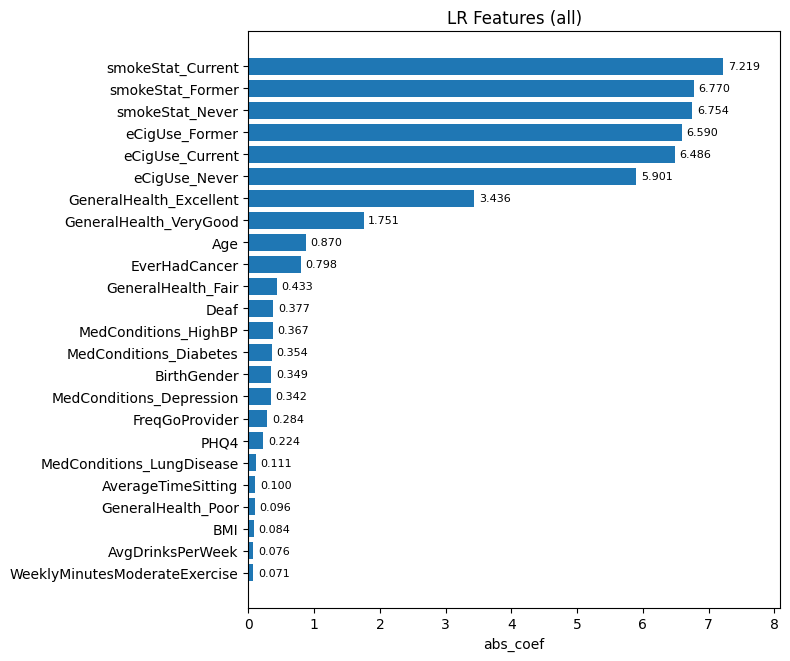

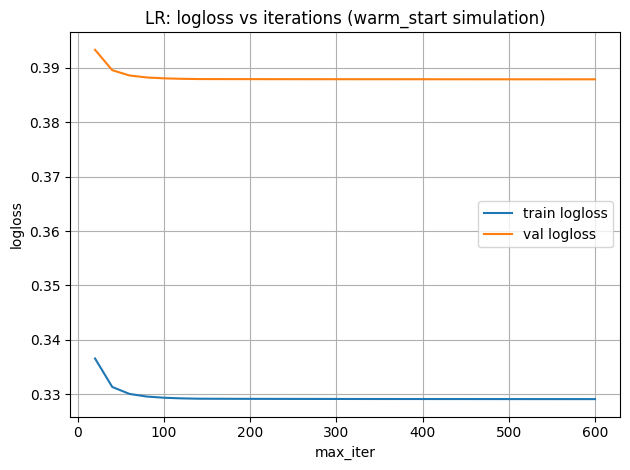

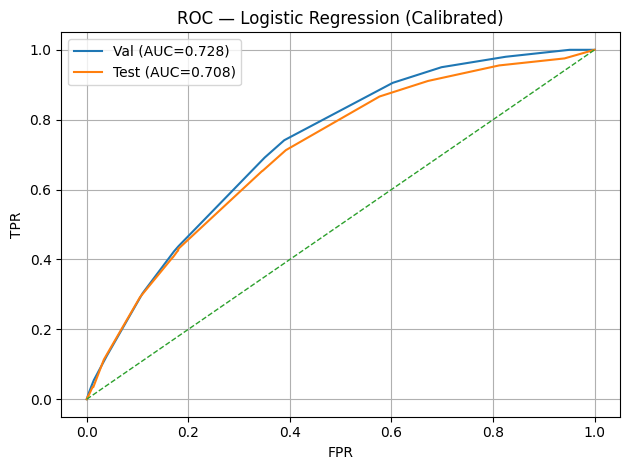

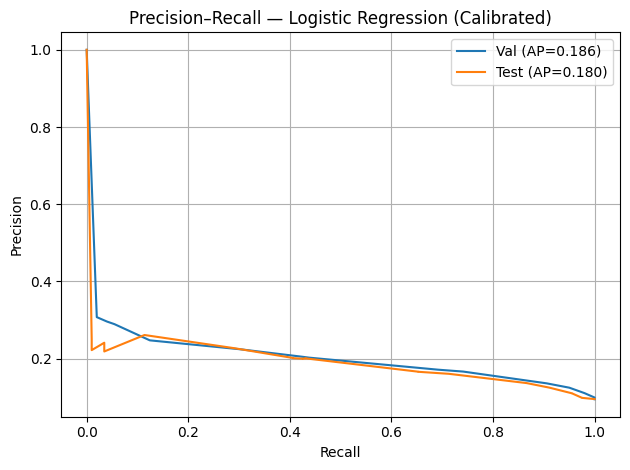

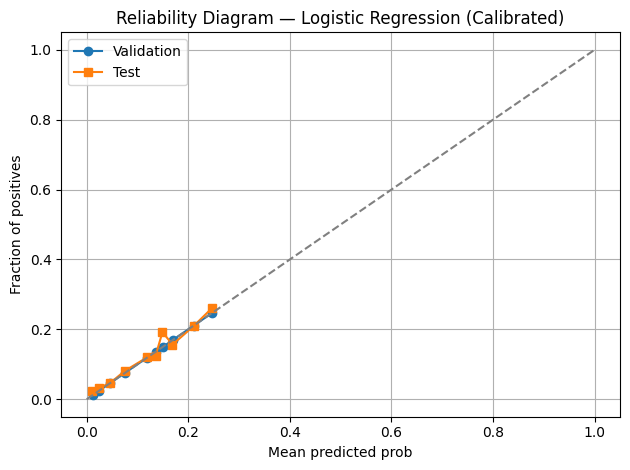

In [35]:
from utils import pipeline_lr as pipeline_lr
import importlib
importlib.reload(pipeline_lr)
# Control how many features to export/plot:
# - set explicitly via topn_features (e.g., 30)
# - or set CONFIGS['LR_TOPN_FEATURES'] (overrides the arg if present)
topn = CONFIGS.get('LR_TOPN_FEATURES', 30)   # use None or 0 for ALL features

results["lr"] = pipeline_lr.train_validate_test_lr(
    X_train_res_scaled_WSA, y_train_res_WSA,
    X_val_scaled_WSA, y_val_WSA,
    X_test_scaled_WSA, y_test_WSA,
    feature_names=list(X_train_res_scaled_WSA.columns),
    C_grid=[0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
    penalty="l2",
    prefer_saga=True,
    max_iter=600,
    threshold_metric="f1",           # or "youden"
    topn_features=topn,              # <— controls feature export; 0/None = ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251120_182920/rf
[RF] Hyperparam scan (n_estimators, max_depth, min_samples_leaf):
  n=300  depth=None  leaf=1   val_logloss=0.3249  val_auc=0.7433
  n=300  depth=None  leaf=2   val_logloss=0.3333  val_auc=0.7493
  n=300  depth=None  leaf=4   val_logloss=0.3502  val_auc=0.7487
  n=300  depth=12    leaf=1   val_logloss=0.3657  val_auc=0.7433
  n=300  depth=12    leaf=2   val_logloss=0.3680  val_auc=0.7424
  n=300  depth=12    leaf=4   val_logloss=0.3748  val_auc=0.7439
  n=300  depth=20    leaf=1   val_logloss=0.3282  val_auc=0.7444
  n=300  depth=20    leaf=2   val_logloss=0.3355  val_auc=0.7496
  n=300  depth=20    leaf=4   val_logloss=0.3503  val_auc=0.7516
  n=600  depth=None  leaf=1   val_logloss=0.3243  val_auc=0.7470
  n=600  depth=None  leaf=2   val_logloss=0.3336  val_auc=0.7505
  n=600  depth=None  leaf=4   val_logloss=0.3505  val_auc=0.7508
  n=600  depth=12    leaf=1   val_logloss=0.3

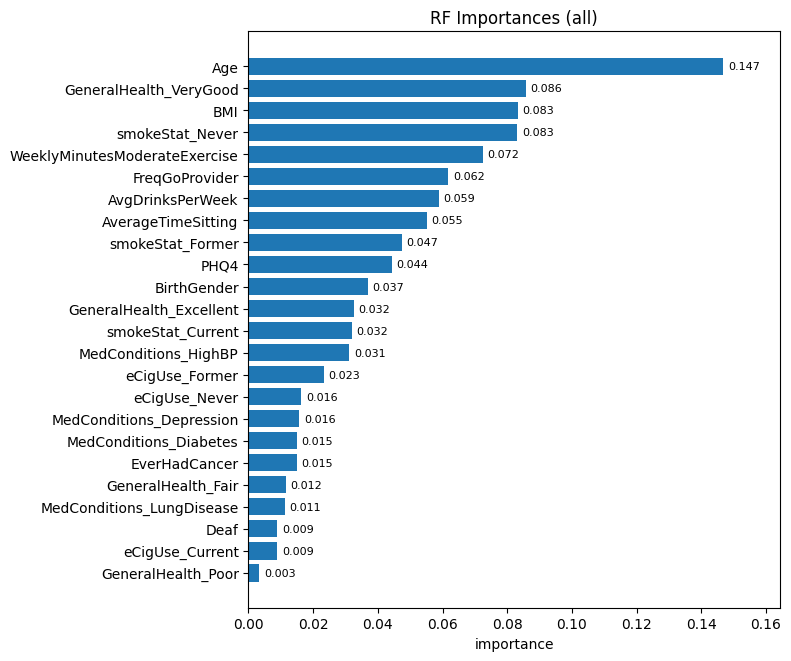

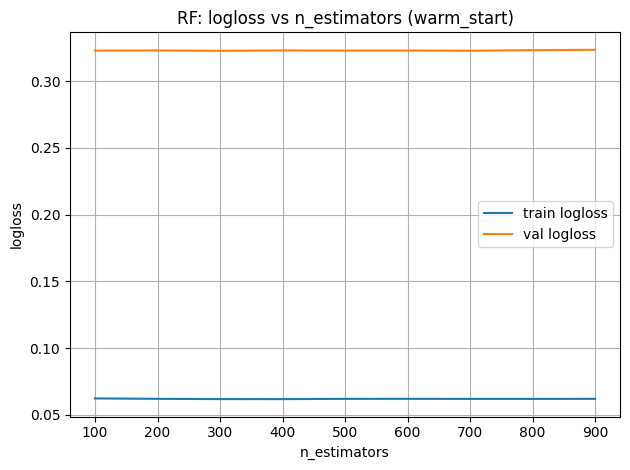

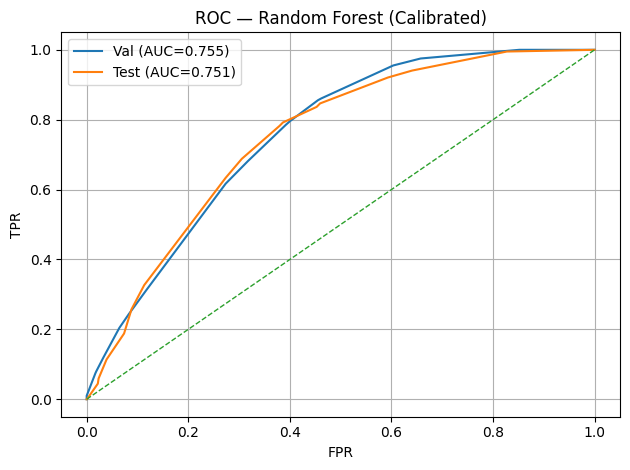

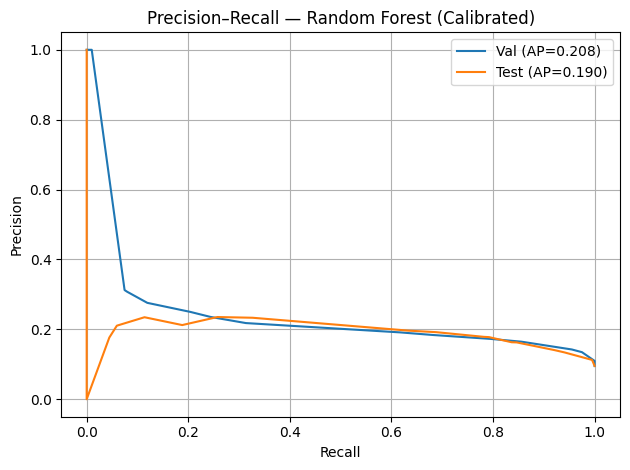

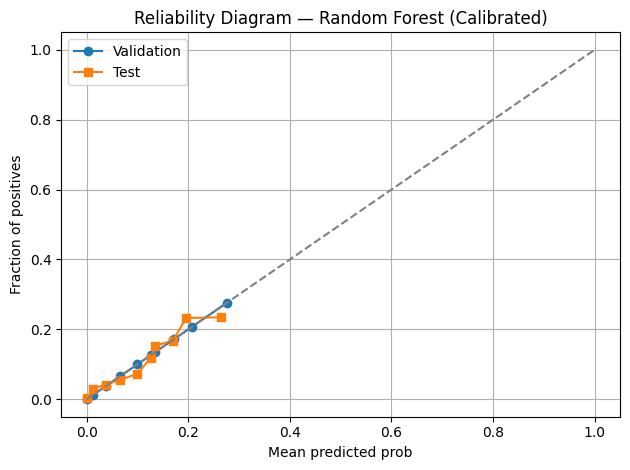

In [30]:
from utils import pipeline_rf as pipeline_rf
import importlib
importlib.reload(pipeline_rf)

results["rf_wsa"] = pipeline_rf.train_validate_test_rf(
    X_train_res_scaled_WSA, y_train_res_WSA,
    X_val_scaled_WSA, y_val_WSA,
    X_test_scaled_WSA, y_test_WSA,
    feature_names=list(X_train_res_scaled_WSA.columns),
    n_estimators_grid=[300, 600, 900],
    max_depth_grid=[None, 12, 20],
    min_samples_leaf_grid=[1, 2, 4],
    max_features="sqrt",
    class_weight="balanced_subsample",
    warm_curve_step=100,
    max_estimators_curve=900,
    random_state=CONFIGS.get('RANDOM_STATE', 42),
    threshold_metric="f1",             # or "youden"
    topn_features=CONFIGS.get('RF_TOPN_FEATURES', 30),   # 0/None => ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved RF outputs dir:", results["rf_wsa"]["outdir"])
print("RF used top-n:", results["rf_wsa"]["used_topn_features"])
print(results["rf_wsa"]["features"].head(10).to_string(index=False))


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251120_182920/rf
[RF] Hyperparam scan (n_estimators, max_depth, min_samples_leaf):
  n=300  depth=None  leaf=1   val_logloss=0.3362  val_auc=0.7442
  n=300  depth=None  leaf=2   val_logloss=0.3468  val_auc=0.7418
  n=300  depth=None  leaf=4   val_logloss=0.3633  val_auc=0.7400
  n=300  depth=12    leaf=1   val_logloss=0.3773  val_auc=0.7360
  n=300  depth=12    leaf=2   val_logloss=0.3824  val_auc=0.7325
  n=300  depth=12    leaf=4   val_logloss=0.3862  val_auc=0.7375
  n=300  depth=20    leaf=1   val_logloss=0.3389  val_auc=0.7400
  n=300  depth=20    leaf=2   val_logloss=0.3488  val_auc=0.7387
  n=300  depth=20    leaf=4   val_logloss=0.3632  val_auc=0.7412
  n=600  depth=None  leaf=1   val_logloss=0.3368  val_auc=0.7423
  n=600  depth=None  leaf=2   val_logloss=0.3475  val_auc=0.7425
  n=600  depth=None  leaf=4   val_logloss=0.3642  val_auc=0.7400
  n=600  depth=12    leaf=1   val_logloss=0.3

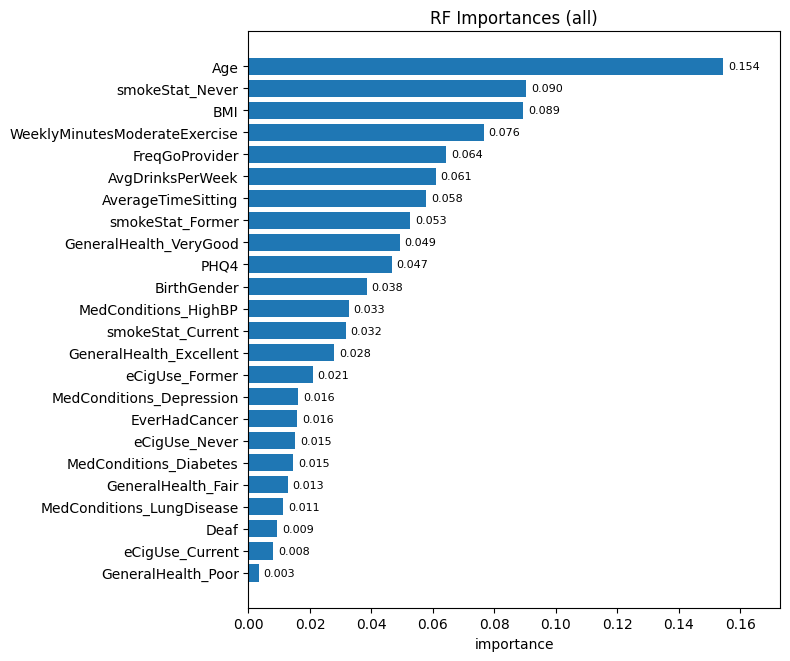

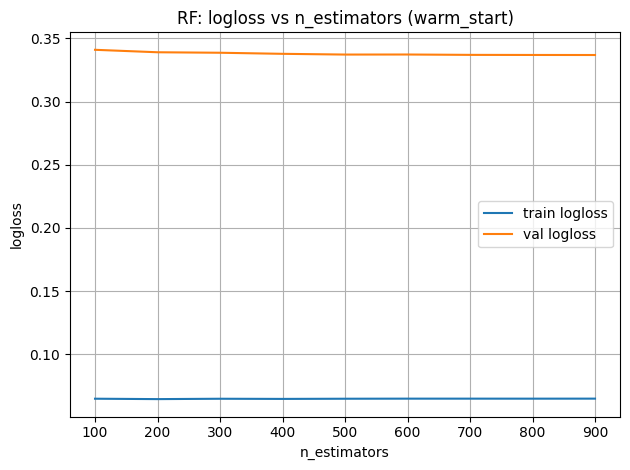

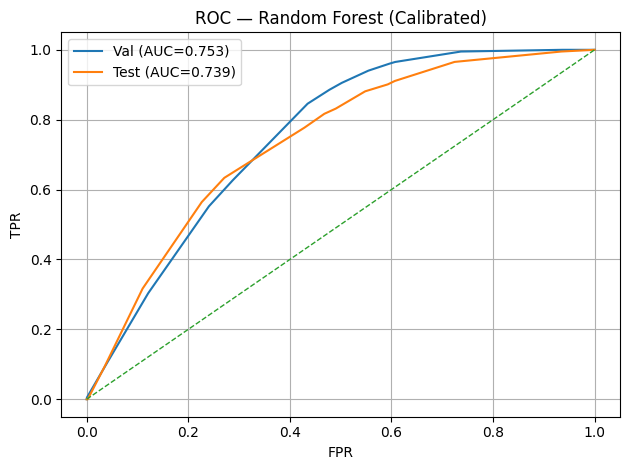

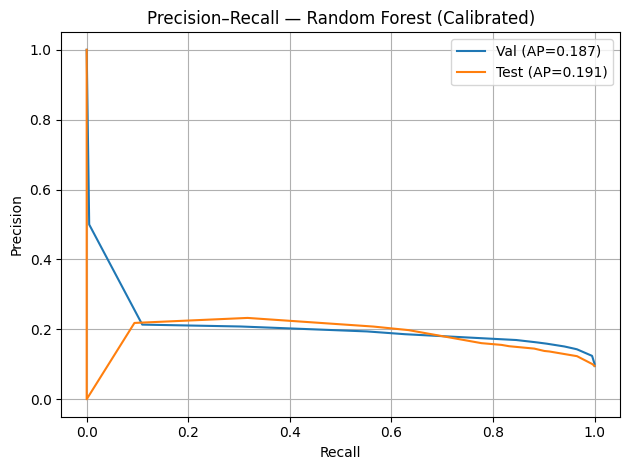

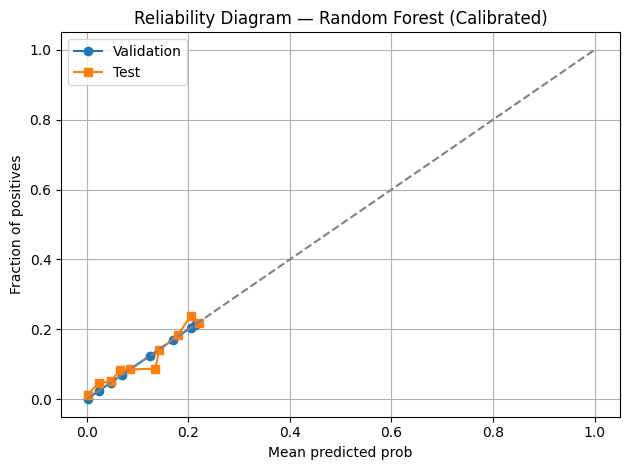

In [31]:
from utils import pipeline_rf as pipeline_rf
import importlib
importlib.reload(pipeline_rf)

results["rf_rf"] = pipeline_rf.train_validate_test_rf(
    X_train_res_scaled_rf, y_train_res_rf,
    X_val_scaled_rf, y_val_rf,
    X_test_scaled_rf, y_test_rf,
    feature_names=list(X_train_res_scaled_WSA.columns),
    n_estimators_grid=[300, 600, 900],
    max_depth_grid=[None, 12, 20],
    min_samples_leaf_grid=[1, 2, 4],
    max_features="sqrt",
    class_weight="balanced_subsample",
    warm_curve_step=100,
    max_estimators_curve=900,
    random_state=CONFIGS.get('RANDOM_STATE', 42),
    threshold_metric="f1",             # or "youden"
    topn_features=CONFIGS.get('RF_TOPN_FEATURES', 30),   # 0/None => ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved RF outputs dir:", results["rf_rf"]["outdir"])
print("RF used top-n:", results["rf_rf"]["used_topn_features"])
print(results["rf_rf"]["features"].head(10).to_string(index=False))

[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/xgb
[XGB] Hyperparam scan:
  n=600  lr=0.03 depth=4  mcw=1.0 sub=0.8 col=0.7  val_logloss=0.2935  val_auc=0.7630  (best_it=597)
  n=600  lr=0.03 depth=4  mcw=1.0 sub=0.8 col=0.9  val_logloss=0.2948  val_auc=0.7598  (best_it=592)
  n=600  lr=0.03 depth=4  mcw=3.0 sub=0.8 col=0.7  val_logloss=0.2943  val_auc=0.7614  (best_it=597)
  n=600  lr=0.03 depth=4  mcw=3.0 sub=0.8 col=0.9  val_logloss=0.2954  val_auc=0.7595  (best_it=596)
  n=600  lr=0.03 depth=6  mcw=1.0 sub=0.8 col=0.7  val_logloss=0.2922  val_auc=0.7582  (best_it=398)
  n=600  lr=0.03 depth=6  mcw=1.0 sub=0.8 col=0.9  val_logloss=0.2905  val_auc=0.7642  (best_it=335)
  n=600  lr=0.03 depth=6  mcw=3.0 sub=0.8 col=0.7  val_logloss=0.2927  val_auc=0.7593  (best_it=364)
  n=600  lr=0.03 depth=6  mcw=3.0 sub=0.8 col=0.9  val_logloss=0.2918  val_auc=0.7597  (best_it=381)
  n=600  lr=0.03 depth=8  mcw=1.0 sub=0.8 col=0.7  val_logl

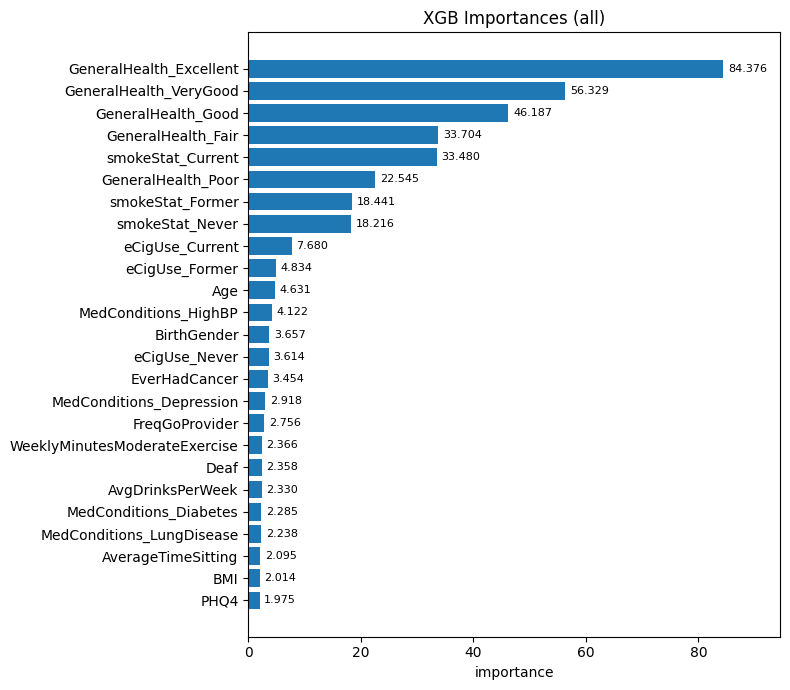

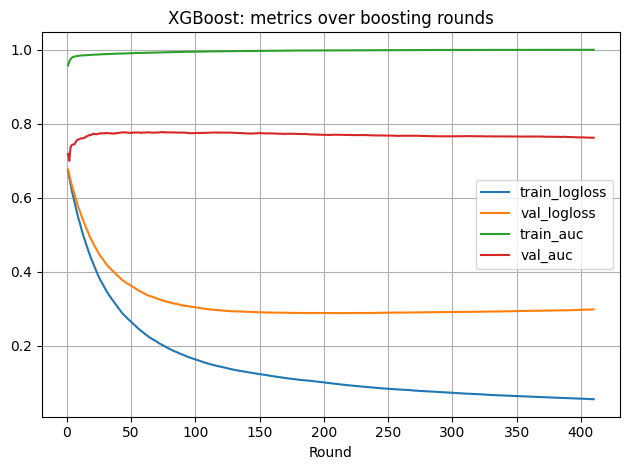

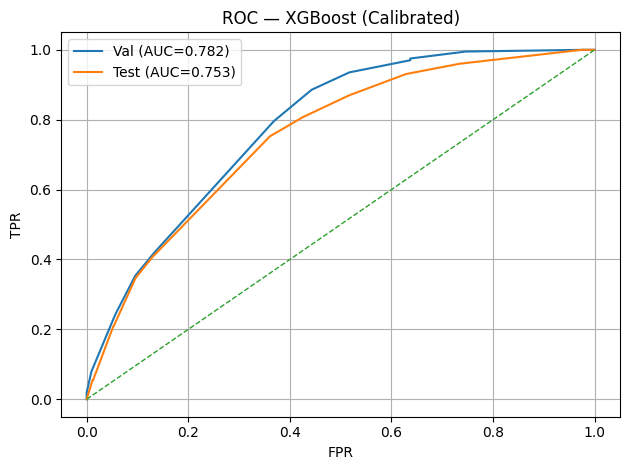

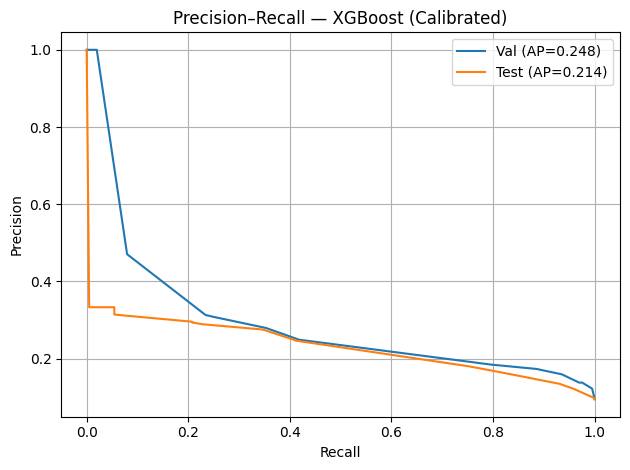

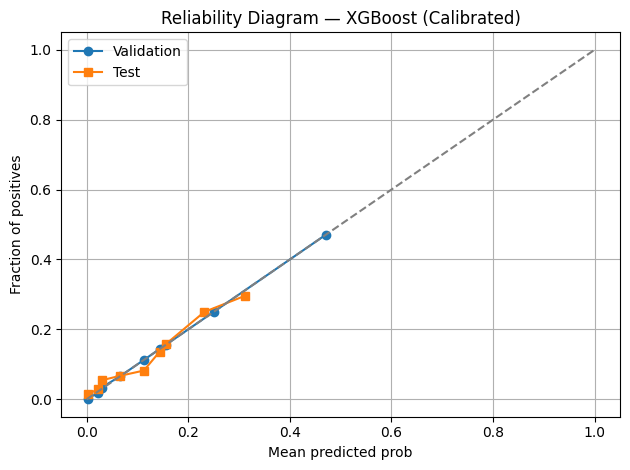

In [14]:
from utils import pipeline_xgb as pipeline_xgb
import importlib
importlib.reload(pipeline_xgb)


# Control how many features to export/plot:
# - set explicitly via topn_features (e.g., 30)
# - or set CONFIGS['XGB_TOPN_FEATURES'] (overrides the arg if present)
xgb_topn = CONFIGS.get('XGB_TOPN_FEATURES', 30)  # 0/None => ALL

results["xgb"] = pipeline_xgb.train_validate_test_xgb(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    n_estimators_grid=[600, 1200, 2000],
    learning_rate_grid=[0.03, 0.05],
    max_depth_grid=[4, 6, 8],
    min_child_weight_grid=[1.0, 3.0],
    subsample_grid=[0.8],
    colsample_bytree_grid=[0.7, 0.9],
    reg_lambda=1.0,
    early_stopping_rounds=200,
    random_state=CONFIGS.get('RANDOM_STATE', 42),
    threshold_metric="f1",          # or "youden"
    topn_features=xgb_topn,         # 0/None => ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved XGB outputs dir:", results["xgb"]["outdir"])
print("XGB used top-n:", results["xgb"]["used_topn_features"])
print(results["xgb"]["features"].head(10).to_string(index=False))


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/xlstm
[XLSTM] CUDA OOM creating model; fallback to CPU.
[XLSTM] epoch=001 train_loss=0.6859 val_logloss=0.6638 val_auc=0.4287
[XLSTM] epoch=005 train_loss=0.3426 val_logloss=0.3518 val_auc=0.5507
[XLSTM] epoch=010 train_loss=0.3234 val_logloss=0.3484 val_auc=0.6586
[XLSTM] epoch=015 train_loss=0.2987 val_logloss=0.3332 val_auc=0.7156
[XLSTM] epoch=020 train_loss=0.2719 val_logloss=0.3133 val_auc=0.7417
[XLSTM] epoch=025 train_loss=0.2586 val_logloss=0.3097 val_auc=0.7384
[XLSTM] epoch=030 train_loss=0.2454 val_logloss=0.3202 val_auc=0.7276
[XLSTM] epoch=035 train_loss=0.2429 val_logloss=0.3004 val_auc=0.7295
[XLSTM] epoch=040 train_loss=0.2375 val_logloss=0.2889 val_auc=0.7413
[XLSTM] epoch=045 train_loss=0.2297 val_logloss=0.3044 val_auc=0.7409
[XLSTM] epoch=050 train_loss=0.2226 val_logloss=0.2958 val_auc=0.7424
[XLSTM] epoch=055 train_loss=0.2174 val_logloss=0.3297 val_auc=0.711

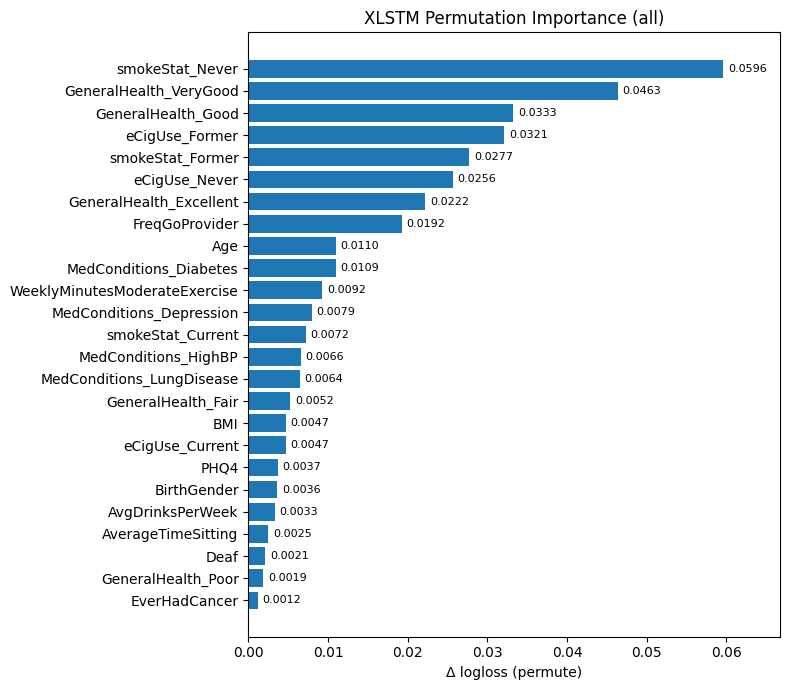

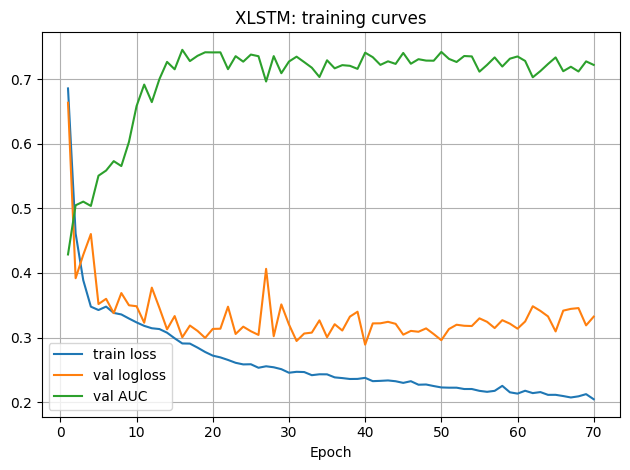

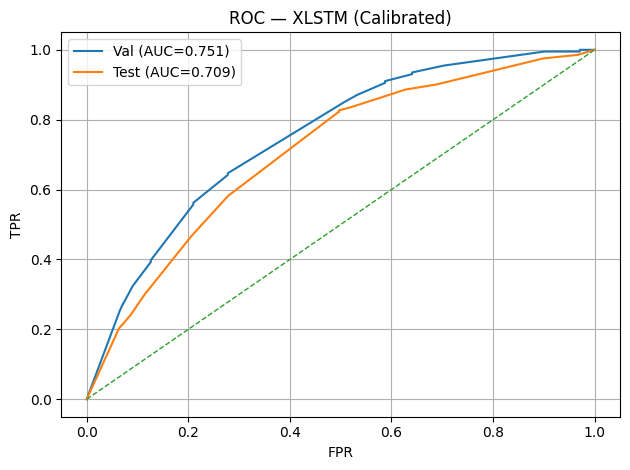

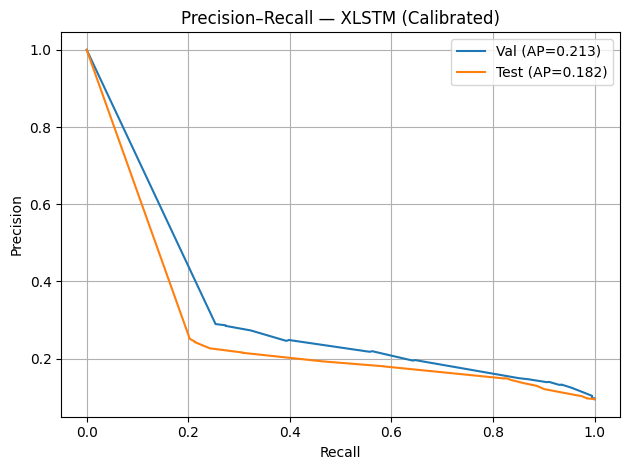

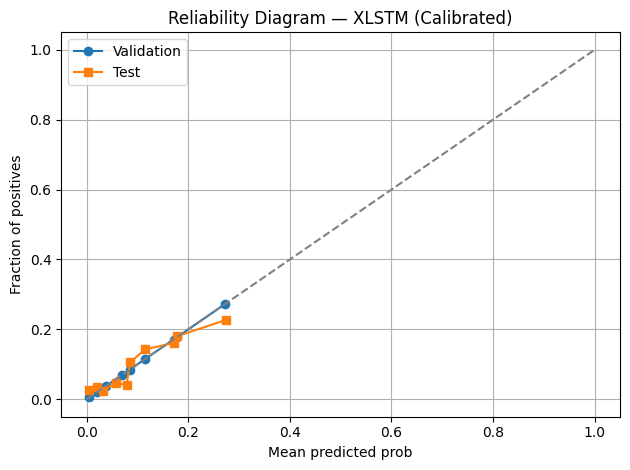

In [15]:
from utils import pipeline_xlstm as pipeline_xlstm
import importlib
importlib.reload(pipeline_xlstm)

# Control how many features to export/plot:
xlstm_topn = CONFIGS.get('XLSTM_TOPN_FEATURES', 30)  # 0/None => ALL

results["xlstm"] = pipeline_xlstm.train_validate_test_xlstm(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    hidden_dim=CONFIGS.get("XLSTM_HIDDEN", 64),
    num_layers=CONFIGS.get("XLSTM_LAYERS", 2),
    dropout=CONFIGS.get("XLSTM_DROPOUT", 0.2),
    lr=CONFIGS.get("XLSTM_LR", 1e-3),
    batch_size=CONFIGS.get("XLSTM_BS", 256),
    max_epochs=CONFIGS.get("XLSTM_EPOCHS", 120),
    patience=CONFIGS.get("XLSTM_PATIENCE", 30),
    random_state=CONFIGS.get("RANDOM_STATE", 42),
    threshold_metric="f1",            # or "youden"
    topn_features=xlstm_topn,         # 0/None => ALL
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved XLSTM outputs dir:", results["xlstm"]["outdir"])
print("Top features (head):\n", results["xlstm"]["features"].head(10).to_string(index=False))


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/tabnet
[TABNET] Device preference: cuda (cuda_available=True)
[TABNET] Hyperparam scan (n_d/steps/batch_size):
[TABNET] CUDA trial failed (cuda error: out of memory
cuda kernel errors might be asynchronously reported at...) → falling back to CPU

Early stopping occurred at epoch 14 with best_epoch = 6 and best_val_logloss = 0.28241


/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  n_d=12   steps=3  bs=128  dev=cpu   val_logloss=0.2824  val_auc=0.7694
[TABNET] CUDA trial failed (cuda error: out of memory
cuda kernel errors might be asynchronously reported at...) → falling back to CPU

Early stopping occurred at epoch 18 with best_epoch = 10 and best_val_logloss = 0.28634


/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  n_d=12   steps=3  bs=256  dev=cpu   val_logloss=0.2863  val_auc=0.7470
[TABNET] CUDA trial failed (cuda error: out of memory
cuda kernel errors might be asynchronously reported at...) → falling back to CPU

Early stopping occurred at epoch 33 with best_epoch = 25 and best_val_logloss = 0.28105


/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  n_d=12   steps=4  bs=128  dev=cpu   val_logloss=0.2811  val_auc=0.7596
[TABNET] Best: n_d=12, steps=4, batch_size=128
[TABNET] Isotonic calibration done on validation.
[TABNET][THRESH] best_t=0.150 (f1=0.3308)

Best threshold (F1 on VAL): 0.15

🔎 Validation Accuracy (threshold=0.15): 0.79
Classification Report (Validation):
              precision    recall  f1-score   support

     Class 0       0.94      0.82      0.88      1915
     Class 1       0.24      0.55      0.33       201

    accuracy                           0.79      2116
   macro avg       0.59      0.68      0.60      2116
weighted avg       0.88      0.79      0.82      2116

AUC-ROC (Validation): 0.77

Best threshold (F1): 0.15

🔎 Test Accuracy (threshold=0.15): 0.78
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.81      0.87      1915
     Class 1       0.21      0.47      0.29       202

    accuracy                           0.78      2117
   macro a

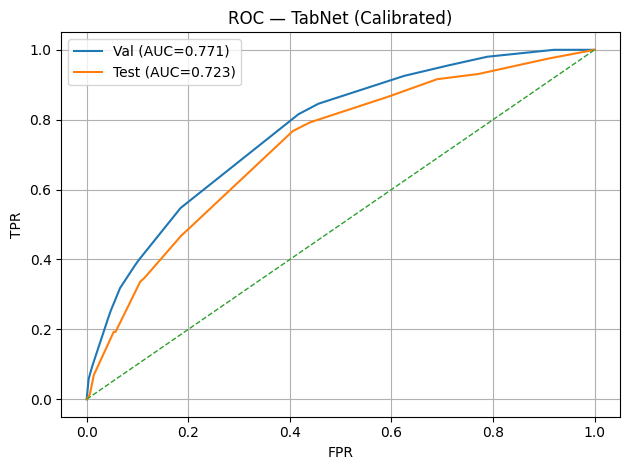

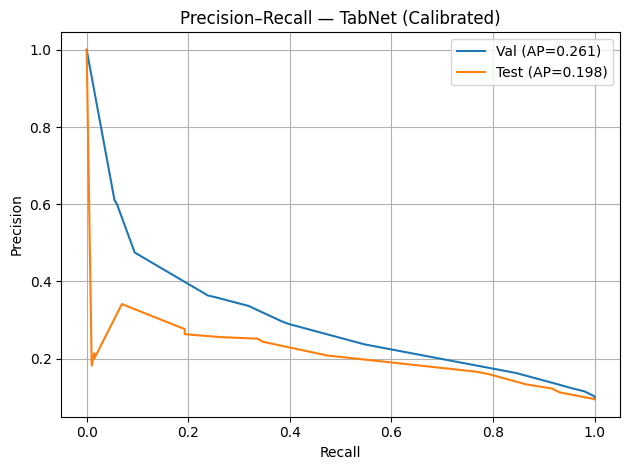

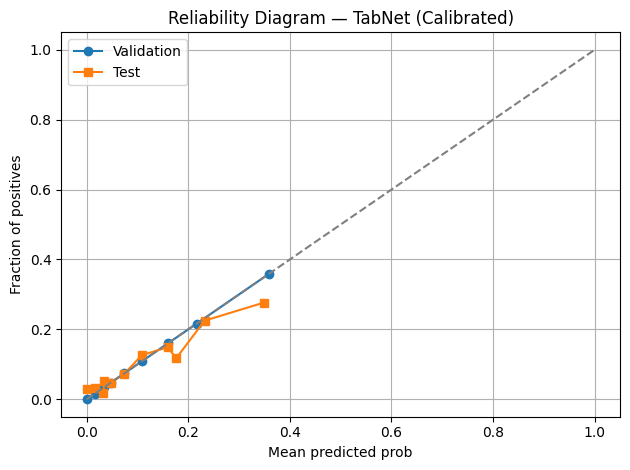

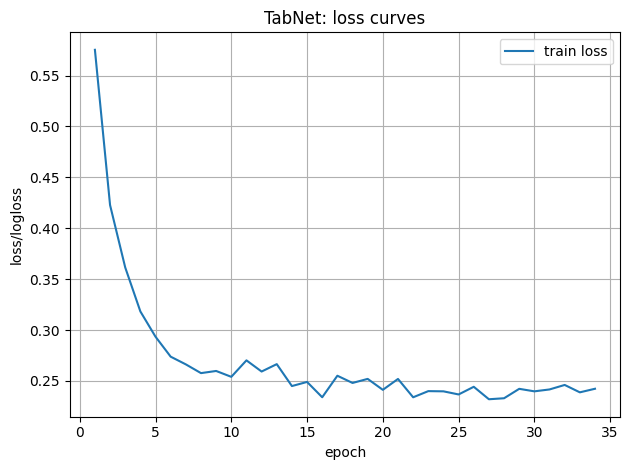

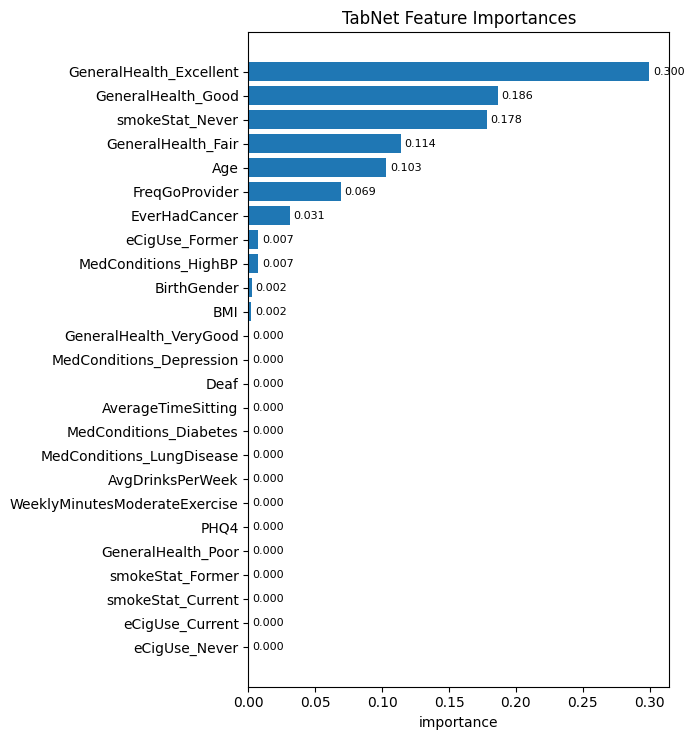

In [16]:
from utils import pipeline_tabnet as pipeline_tabnet
import importlib
importlib.reload(pipeline_tabnet)

tabnet_topn = CONFIGS.get('TABNET_TOPN_FEATURES', 30)  # 0/None => ALL

results["tabnet"] = pipeline_tabnet.train_validate_test_tabnet(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    width=CONFIGS.get("TABNET_WIDTH", 24),
    n_steps=CONFIGS.get("TABNET_STEPS", 4),
    gamma=CONFIGS.get("TABNET_GAMMA", 1.5),
    lambda_sparse=CONFIGS.get("TABNET_LAMBDA_SPARSE", 1e-5),
    mask_type=CONFIGS.get("TABNET_MASK", "sparsemax"),
    lr=CONFIGS.get("TABNET_LR", 6e-4),
    weight_decay=CONFIGS.get("TABNET_WEIGHT_DECAY", 1e-4),
    max_epochs=CONFIGS.get("TABNET_EPOCHS", 120),
    patience=CONFIGS.get("TABNET_PATIENCE", 40),
    batch_size=CONFIGS.get("TABNET_BS", 256),
    virtual_batch_size=CONFIGS.get("TABNET_VBS", 32),
    cat_idxs=CONFIGS.get("CAT_IDXS", None),
    cat_dims=CONFIGS.get("CAT_DIMS", None),
    cat_emb_dim=CONFIGS.get("CAT_EMB_DIM", 8),
    threshold_metric="f1",
    topn_features=tabnet_topn,
    CONFIGS=CONFIGS,
    device='cuda',     # force CUDA if available (falls back on OOM)
    max_trials=3,      # keep scan snappy
    early_stop_no_improve=1,
    save_outputs=True
)


[SAVE] Output directory: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/mlp
[MLP] Hyperparam scan:
  h=(128, 64)  alpha=0.0001  val_logloss=0.4474  val_auc=0.7276
  h=(128, 64)  alpha=0.0005  val_logloss=0.3439  val_auc=0.7209
  h=(128,)  alpha=0.0001  val_logloss=0.3010  val_auc=0.7592
  h=(128,)  alpha=0.0005  val_logloss=0.3046  val_auc=0.7489
  h=(64,)  alpha=0.0001  val_logloss=0.2985  val_auc=0.7724
  h=(64,)  alpha=0.0005  val_logloss=0.2985  val_auc=0.7724
  h=(256, 128)  alpha=0.0001  val_logloss=0.5221  val_auc=0.7083
  h=(256, 128)  alpha=0.0005  val_logloss=0.7595  val_auc=0.6922
[MLP] Best hidden=(64,), alpha=0.0005 selected by val_logloss (tie-break AUC).
[MLP] Isotonic calibration done on validation.
[MLP][THRESH] best_t=0.200 (f1=0.3436)

Best threshold (F1 on VAL): 0.20

🔎 Validation Accuracy (threshold=0.20): 0.86
Classification Report (Validation):
              precision    recall  f1-score   support

     Class 0       0.93      0.

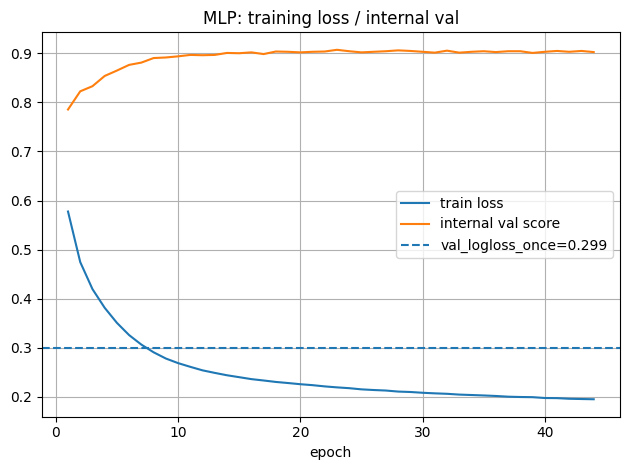

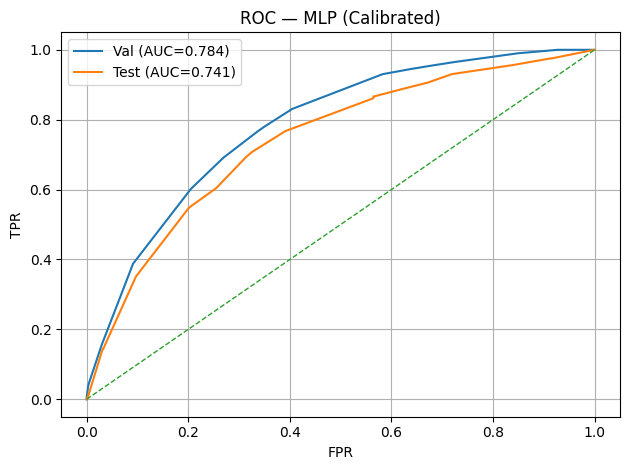

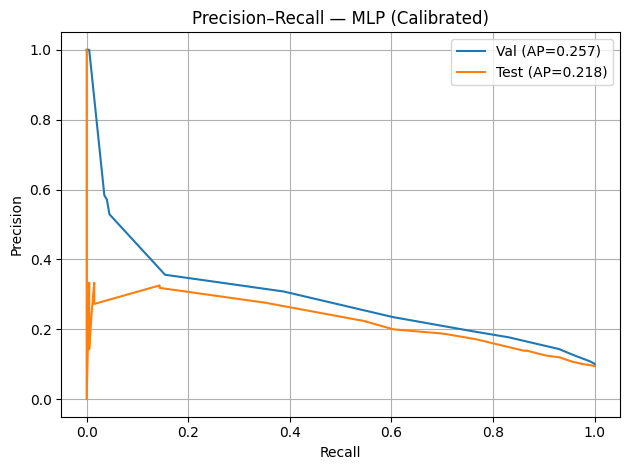

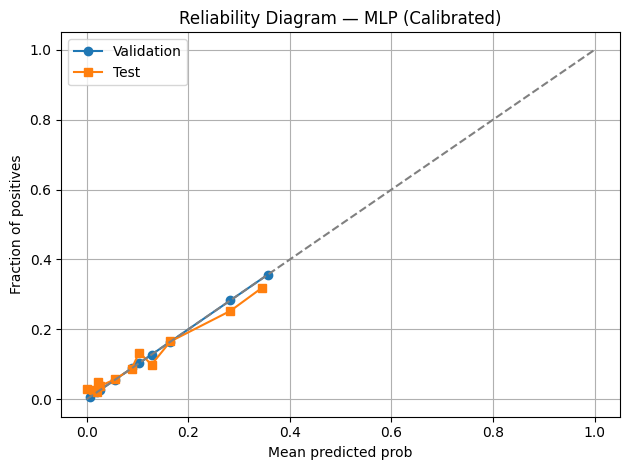

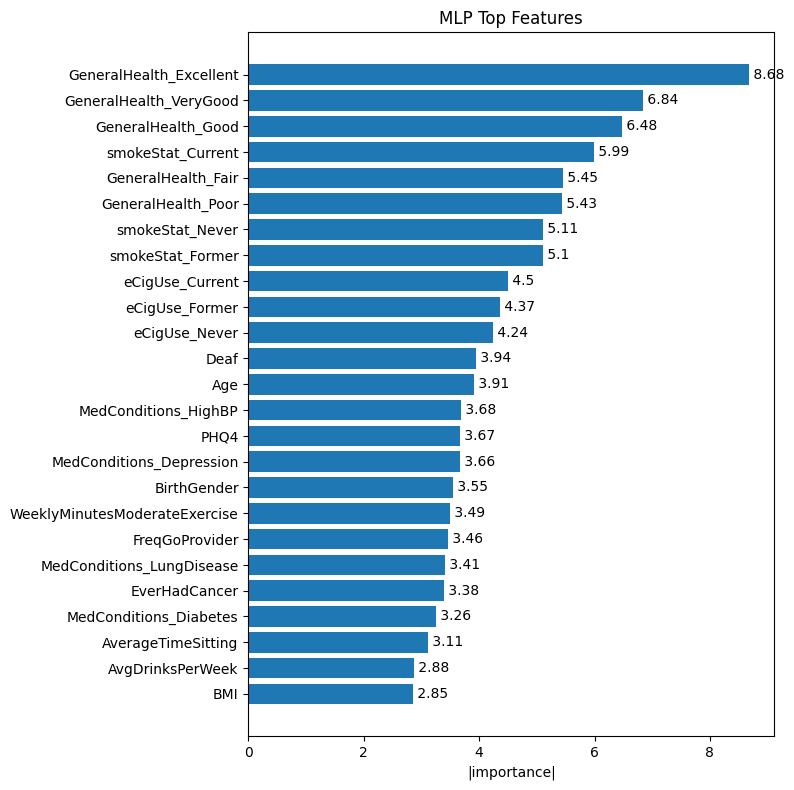

In [17]:
import utils.pipeline_mlp as pipeline_mlp

import importlib
importlib.reload(pipeline_mlp)

# Control how many features to export/plot:
mlp_topn = CONFIGS.get('MLP_TOPN_FEATURES', 30)   # 0/None => ALL

results["mlp"] = pipeline_mlp.train_validate_test_mlp(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    hidden_grid=[(128,64), (128,), (64,), (256,128)],
    alpha_grid=[1e-4, 5e-4],
    learning_rate_init=8e-4,
    max_iter=400,
    random_state=CONFIGS.get("RANDOM_STATE", 42),
    threshold_metric="f1",         # or "youden"
    topn_features=mlp_topn,        # 0/None => ALL features
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved MLP dir:", results["mlp"]["outdir"])
print("\nVal summary:\n", results["mlp"]["val_summary_df"])
print("\nTest summary:\n", results["mlp"]["test_summary_df"])
print("\nTop features (head):\n", results["mlp"]["features"].head(10).to_string(index=False))


In [18]:
import utils.shap_utils as shap_utils

import importlib
importlib.reload(shap_utils)

<module 'utils.shap_utils' from '/home/ppanta/puru_proj/proj_v0/hints6_v0/utils/shap_utils.py'>

In [20]:
# Use actual estimators
models = {
    "lr":    results["lr"]["lr_raw"],
    "rf":    results["rf"]["rf_raw"],
    "xgb":   results["xgb"]["xgb_raw"],
    "mlp":   results["mlp"]["mlp_raw"],
    "xlstm": results["xlstm"]["xlstm_model"],
    # "tabnet": results["tabnet"]["tabnet_model"],  # add if you have it. Tabnet normally dont use external SHAP. It provides its importance value itself.
}

# Provide test matrices; others fall back to "default"
X_by_model = {
    "lr": X_test_scaled,   # if RF/XGB used raw features, add: "rf": X_test_raw, "xgb": X_test_raw
    "default": X_test_scaled
}

global_csv_path = shap_utils.write_shap_reports(
    models=models,
    X_by_model=X_by_model,
    feature_names=list(X_test_scaled.columns),
    CONFIGS=CONFIGS,
    verbose=True
)



 =====> SHAP Analysis (permutation) for Logistic Regression (lr) starting ... <=====
 =====> SHAP Analysis for Logistic Regression (lr) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/lr/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for Logistic Regression (lr) end. <=====

 =====> SHAP Analysis (permutation) for Random Forest (rf) starting ... <=====
 =====> SHAP Analysis for Random Forest (rf) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/rf/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for Random Forest (rf) end. <=====

 =====> SHAP Analysis (permutation) for XGBoost (xgb) starting ... <=====
 =====> SHAP Analysis for XGBoost (xgb) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/xgb/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for XGBoost (xgb) end. <=====

 =====> SHAP A

PermutationExplainer explainer: 2118it [00:29, 47.21it/s]                                                                                                                                                                                    


 =====> SHAP Analysis for Neural Network (MLP) (mlp) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/mlp/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for Neural Network (MLP) (mlp) end. <=====

 =====> SHAP Analysis (permutation) for XLSTM (xlstm) starting ... <=====


PermutationExplainer explainer: 2118it [09:43,  3.57it/s]                                                                                                                                                                                    

 =====> SHAP Analysis for XLSTM (xlstm) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/xlstm/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for XLSTM (xlstm) end. <=====
 =====> SHAP Analysis for all models (lr, rf, xgb, mlp, xlstm) done and result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/global_shap_20251118_101434.csv saved <=====


In [21]:
# assuming you already have: results dict, CONFIGS, feature_names, and per-model X_test matrices
# tip: pass a 'default' in X_by_model if most models share the same test matrix

models = {}
models = {k: results[k] for k in ["lr","rf","mlp","xgb","xlstm","tabnet"] if k in results}

X_by_model = {
    "lr": X_test_scaled,
    "rf": X_test,        # adjust per your pipelines
    "mlp": X_test_scaled,
    "xgb": X_test,
    "xlstm": X_test_scaled,
    "tabnet": X_test,
    "default": X_test_scaled
}

# import shap_utils
global_csv_path = shap_utils.write_shap_reports(
    models=models,
    X_by_model=X_by_model,
    feature_names=list(X_by_model["default"].columns),
    CONFIGS=CONFIGS
)
print("Global SHAP:", global_csv_path)



 =====> SHAP Analysis (permutation) for Logistic Regression (lr) starting ... <=====
 =====> SHAP Analysis for Logistic Regression (lr) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/lr/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for Logistic Regression (lr) end. <=====

 =====> SHAP Analysis (permutation) for Random Forest (rf) starting ... <=====
 =====> SHAP Analysis for Random Forest (rf) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/rf/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for Random Forest (rf) end. <=====

 =====> SHAP Analysis (permutation) for Neural Network (MLP) (mlp) starting ... <=====


PermutationExplainer explainer: 2118it [00:29, 47.25it/s]                                                                                                                                                                                    


 =====> SHAP Analysis for Neural Network (MLP) (mlp) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/mlp/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for Neural Network (MLP) (mlp) end. <=====

 =====> SHAP Analysis (permutation) for XGBoost (xgb) starting ... <=====
 =====> SHAP Analysis for XGBoost (xgb) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/xgb/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for XGBoost (xgb) end. <=====

 =====> SHAP Analysis (permutation) for XLSTM (xlstm) starting ... <=====


PermutationExplainer explainer: 2118it [09:44,  3.56it/s]                                                                                                                                                                                    

 =====> SHAP Analysis for XLSTM (xlstm) result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/xlstm/local_shap_20251118_101434.csv saved <=====
 =====> SHAP Analysis for XLSTM (xlstm) end. <=====

 =====> SHAP Analysis (permutation) for TabNet (tabnet) starting ... <=====
##### [WARN] SHAP Analysis for TabNet (tabnet) failed: 0 #####
 =====> SHAP Analysis for all models (lr, rf, mlp, xgb, xlstm) done and result saved on: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/tr_va_te_metric_shap_20251118_101434/global_shap_20251118_101434.csv saved <=====
Global SHAP: op/tr_va_te_metric_shap_20251118_101434/global_shap_20251118_101434.csv


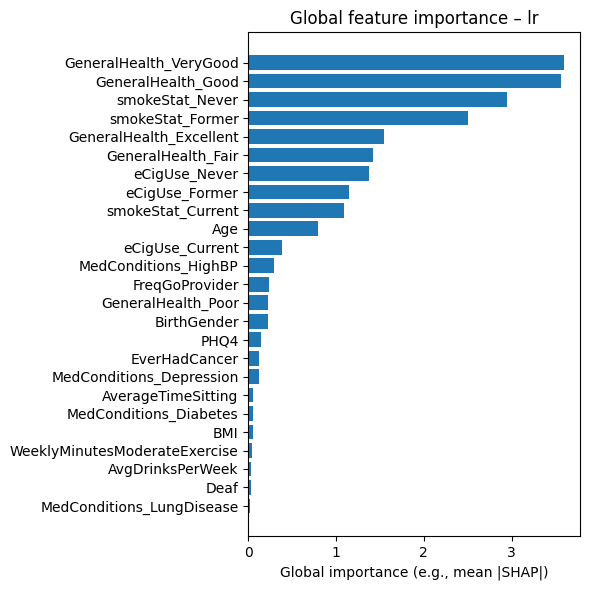

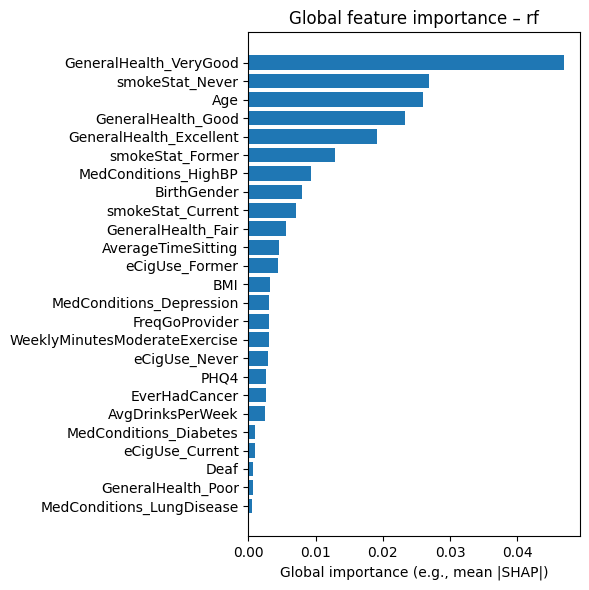

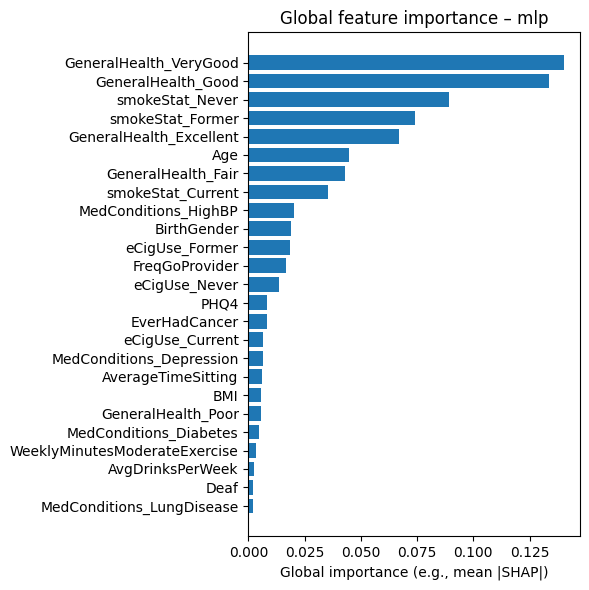

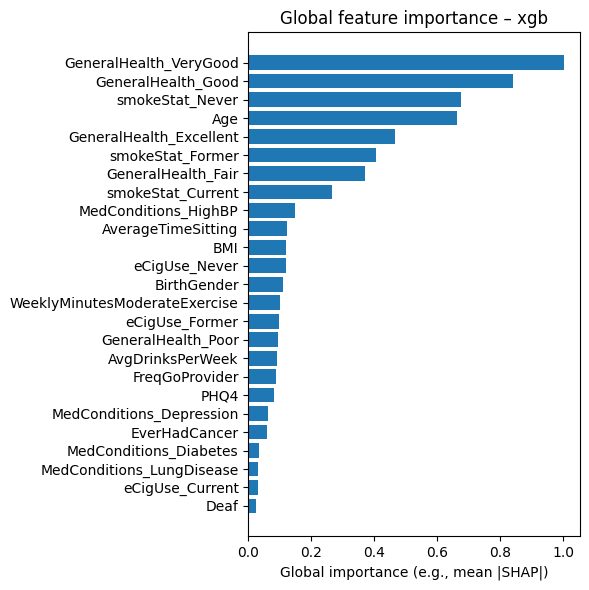

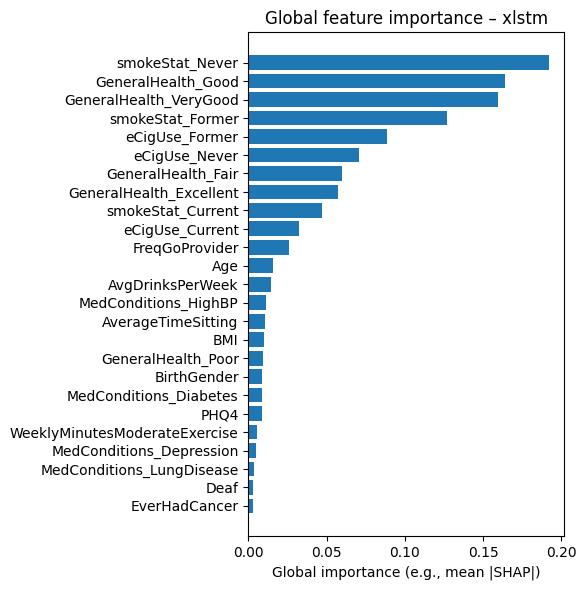

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# path to your global SHAP file
global_csv_path = f"op/tr_va_te_metric_shap_{CONFIGS['RUN_TS']}/global_shap_{CONFIGS['RUN_TS']}.csv"
gdf = pd.read_csv(global_csv_path)

# columns of the form "<model>_shap_abs" are global importance for each model
model_cols = [c for c in gdf.columns if c.endswith("_shap_abs")]

for col in model_cols:
    model_name = col.replace("_shap_abs", "")  # e.g. "rf", "xgb", "lr", "mlp", "xlstm"

    # sort features by importance for this model
    gdf_sorted = gdf.sort_values(col, ascending=False)

    plt.figure(figsize=(6, 6))
    plt.barh(gdf_sorted["feature"], gdf_sorted[col])
    plt.gca().invert_yaxis()  # highest at top
    plt.xlabel("Global importance (e.g., mean |SHAP|)")
    plt.title(f"Global feature importance – {model_name}")
    plt.tight_layout()
    plt.show()


In [ ]:
####
# NOT USING THE FOLLOWING MODEL FOR NOW #
####

In [ ]:
import utils.pipeline_node as pipeline_node
import importlib
importlib.reload(pipeline_node)

node_topn = CONFIGS.get('NODE_TOPN_FEATURES', 30)  # 0/None => ALL

results["node"] = pipeline_node.train_validate_test_node(
    X_train_res_scaled, y_train_res,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=list(X_train_res_scaled.columns),
    num_trees_grid=[64, 128],
    depth_grid=[3, 4],
    lr_grid=[1e-3, 3e-4],
    batch_size_grid=[256, 512],
    max_epochs=CONFIGS.get("NODE_EPOCHS", 120),
    patience=CONFIGS.get("NODE_PATIENCE", 40),
    random_state=CONFIGS.get("RANDOM_STATE", 42),
    threshold_metric="f1",        # or "youden"
    topn_features=node_topn,      # 0/None => ALL features
    CONFIGS=CONFIGS,
    save_outputs=True
)

print("Saved NODE dir:", results["node"]["outdir"])
print("\nVal summary:\n", results["node"]["val_summary_df"])
print("\nTest summary:\n", results["node"]["test_summary_df"])
print("\nTop features (head):\n", results["node"]["features"].head(10).to_string(index=False))
